<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Bayesian Filtering Equations and Exact Solutions

This notebook replicates the figures of Chapter 4 of  Särkkä's "Bayesian Filtering and Smoothing" using JAX.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))



## 4.0 Imports

In [2]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

## 4.1 Probabilistic State Space Models

First, we generate random signal and measurements according to a Gaussian random walk to replicate Figure 4.1

In [86]:
# 1-dimensional random walk simulation
def simulate_rw_1d(init, Q, R, num_steps):
    def _step(carry, rng):
        x_prev = carry

        # Random walk and measurement
        key1, key2 = jr.split(rng)
        x_post = x_prev + jr.normal(key1)*Q
        y = x_post + jr.normal(key2)
        return x_post, (x_post, y)

    carry = init
    rngs = jr.split(jr.PRNGKey(0), num_steps)
    _, (xs, ys) = lax.scan(
        _step, carry, rngs
    )
    return xs, ys

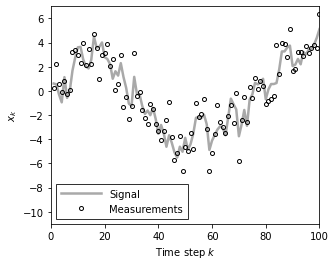

In [87]:
# Generate random walk data with num_steps=100
xs, ys = simulate_rw_1d(0, 1, 1, 100)

# Generate grid
t_grid = jnp.arange(1,101)

# Plot the generated data
plt.figure()
plt.plot(t_grid, xs, color='darkgray', linewidth=2.5, label="Signal")
plt.plot(t_grid, ys, 'ok', fillstyle='none', ms=4, label='Measurements')
plt.xlabel('Time step $k$'); plt.ylabel('$x_k$')
plt.xlim(0, 100); plt.ylim(-11, 7)
plt.yticks(jnp.arange(-10, 7, 2))
plt.gca().set_aspect(4.5)
plt.legend(loc=3, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

## 4.3 Kalman Filter

We use the Kalman filter implemented in the [Chapter 3 notebook](https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch3.ipynb) to replicate Figure 4.4

In [90]:
# Kalman filter assuming constant transition and measurement models
def kalman_filter(m_0, P_0, H, R, A, Q, Y):
    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = A @ m_k
        P_pred = A @ P_k @ A.T + Q

        # Update step
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ jnp.linalg.inv(S)
        m_post = m_pred + K * (Y[t] - H @ m_pred)
        P_post = P_pred - K @ S @ K.T

        return (m_post, P_post), (m_post, P_post)

    num_timesteps = len(Y)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

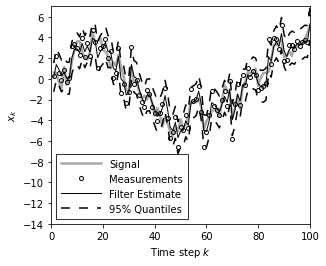

In [137]:
# Run Kalman filter on the 1d random walk data
zero, one = jnp.zeros((1,1)), jnp.ones((1,1))
ms, Ps = kalman_filter(zero, zero, one, one, one, one, ys)
ms, Ps = jnp.ravel(ms), jnp.ravel(Ps)

# 95% confidence interval
ci = 1.96 * jnp.sqrt(Ps)

# Plot the generated data
plt.figure()
plt.plot(t_grid, xs, color='darkgray', linewidth=2.5, label="Signal")
plt.plot(t_grid, ys, 'ok', fillstyle='none', ms=4, label='Measurements')
plt.plot(t_grid, ms, color='k', linewidth=1, label="Filter Estimate")
plt.plot(t_grid, ms-ci, 'k', dashes=[6,6], label="95% Quantiles")
plt.plot(t_grid, ms+ci, 'k', dashes=[6,6])
plt.xlabel('Time step $k$'); plt.ylabel('$x_k$')
plt.xlim(0, 100); plt.ylim(-14, 7)
plt.yticks(jnp.arange(-14, 7, 2))
plt.gca().set_aspect(4)
plt.legend(loc=3, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()